## LSTM training + correlation calc + hybrid eval

#### Importing training data

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
import rpy2.robjects as robjects

folder_name = '3_state_model'

data_log = pd.read_csv(folder_name + "/close_data_log.csv")

# Helper function to convert R data.frame to pandas DataFrame
def r_to_df(r_df):
    return pd.DataFrame({name: np.array(r_df.rx2(name)) for name in r_df.names})

# Read the RDS files using rpy2
readRDS = robjects.r['readRDS']

hmm_stats_r = readRDS(folder_name + "/hmm_stats_df.rds")
hmm_stats_df = r_to_df(hmm_stats_r)

hmm_state_losses = np.array(readRDS(folder_name + "/hmm_state_losses.rds"))
hmm_predictions = np.array(readRDS(folder_name + "/hmm_predictions.rds"))
hmm_ground_truth = np.array(readRDS(folder_name + "/hmm_ground_truth.rds"))
hmm_valid_loss = np.array(readRDS(folder_name + "/hmm_valid_loss.rds"))
hmm_transition_matrix = pd.read_csv(folder_name + "/transition_matrix.csv")

X_train = np.array(readRDS(folder_name + "/lstm_X_train.rds"))
Y_train = np.array(readRDS(folder_name + "/lstm_Y_train.rds"))
X_valid = np.array(readRDS(folder_name + "/lstm_X_valid.rds"))
Y_valid = np.array(readRDS(folder_name + "/lstm_Y_valid.rds"))
X_test = np.array(readRDS(folder_name + "/lstm_X_test.rds"))
Y_test = np.array(readRDS(folder_name + "/lstm_Y_test.rds"))

n_states = Y_train.shape[2]

### Define the model

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.metrics import CategoricalAccuracy, CategoricalCrossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

lstm_units = 32
dense_units = 16
dropout_rate = 0.3
lookback = 5

# Compute Dirichlet parameters and predicted probabilities (for reference, not used in model)
def dirichlet_layer(evidence):
    alpha = evidence + 1
    S = tf.reduce_sum(alpha, axis=-1, keepdims=True)
    probs = alpha / S
    return probs, alpha, S

# Custom evidential loss with annealing
class EvidentialLoss(tf.keras.losses.Loss):
    def __init__(self, annealing_rate=100.0, name='evidential_loss'):
        super().__init__(name=name)
        self.annealing_rate = tf.constant(annealing_rate, dtype=tf.float32)
        self.current_epoch = tf.Variable(0.0, trainable=False, dtype=tf.float32)
    
    def call(self, y_true, evidence):
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=-1, keepdims=True)
        probs = alpha / S
        err = tf.square(y_true - probs)
        var = probs * (1 - probs) / (S + 1)
        
        # Annealing factor for the regularization term
        lambda_ = tf.minimum(1.0, self.current_epoch / self.annealing_rate)
        
        return tf.reduce_mean(tf.reduce_sum(err + lambda_ * var, axis=-1))

# Custom callback to update the current epoch in the loss instance
class AnnealingCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if hasattr(self.model, 'loss') and isinstance(self.model.loss, EvidentialLoss):
            self.model.loss.current_epoch.assign(tf.cast(epoch, tf.float32))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

def make_model():
    model = models.Sequential([
        layers.Input(shape=(lookback, X_train.shape[2])),  # Fixed shape (10, 20)
        
        # LSTM layer with added dropout
        layers.LSTM(lstm_units, dropout=dropout_rate),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_rate),
        # Output raw evidence (non-negative)
        layers.Dense(n_states, activation='softplus')
    ])

    model.compile(
        loss=EvidentialLoss(annealing_rate=100.0),
        optimizer='adam',
        metrics=['accuracy']  # Accuracy on argmax(probs)
    )
    return model

### Train model for each forecast window

In [11]:
lookback = 5
max_horizon = 10

lstm_state_losses = np.full((len(Y_test), max_horizon), np.nan)
lstm_predictions = np.full((len(Y_test), max_horizon, n_states), np.nan)
lstm_ground_truth = np.full((len(Y_test), max_horizon, n_states), np.nan)
lstm_uncertainty = np.full((len(Y_test), max_horizon), np.nan)
last_state = np.full((len(Y_test), max_horizon, n_states), np.nan)
model_list = []

for forecast_horizon in range(0, max_horizon):

    # Clone the model architecture and set weights for each horizon
    model_h = make_model()

    history = model_h.fit(
        X_train[:, -lookback:, :],
        Y_train[:, forecast_horizon, :],
        epochs=25, callbacks=[AnnealingCallback(), early_stopping], verbose=0)
    
    model_list.append(model_h)
    Y_true = Y_test[:, forecast_horizon, :]

    Y_hat = model_h.predict(X_test[:, -lookback:, :])
    
    probs, alpha, S = dirichlet_layer(Y_hat)
    
    eps = 1e-15
    loss = -np.sum(Y_true * np.log(np.clip(probs, eps, 1.0)), axis=1)
    lstm_state_losses[0:len(loss), forecast_horizon] = loss
    lstm_predictions[0:len(loss), forecast_horizon, :] = probs
    lstm_ground_truth[0:len(loss), forecast_horizon, :] = Y_true
    last_state[0:len(loss), forecast_horizon, :] = X_test[:, -1, :n_states]
    lstm_uncertainty[0:len(loss), forecast_horizon] = S[:, 0]

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


### plotting results

In [17]:
# Compute statistics for each column of lstm_state_losses
stats = {
    'mean': np.nanmean(lstm_state_losses, axis=0),
    'median': np.nanmedian(lstm_state_losses, axis=0),
    'P25': np.nanpercentile(lstm_state_losses, 25, axis=0),
    'P75': np.nanpercentile(lstm_state_losses, 75, axis=0),
    'max': np.nanmax(lstm_state_losses, axis=0),
    'min': np.nanmin(lstm_state_losses, axis=0)
}

# Convert to DataFrame for better display
lstm_stats_df = pd.DataFrame(stats)
lstm_stats_df

,mean,median,P25,P75,max,min
0,0.734751,0.678296,0.579866,0.773435,2.797627,0.362863
1,0.775768,0.709019,0.629729,0.779189,2.994867,0.394806
2,0.798113,0.724476,0.672785,0.766468,3.199805,0.390241
3,0.863746,0.768060,0.719671,0.820046,3.023790,0.582862
4,0.854307,0.733595,0.715806,0.758799,3.269134,0.649295
5,0.858830,0.735696,0.713104,0.770320,3.121501,0.612782
6,0.892655,0.793725,0.722588,0.890329,2.523055,0.608336
7,0.871520,0.766124,0.757644,0.780447,2.726208,0.648794
8,0.831142,0.718348,0.700591,0.749005,3.562635,0.690182
9,0.838710,0.738084,0.726537,0.754568,3.092115,0.657293


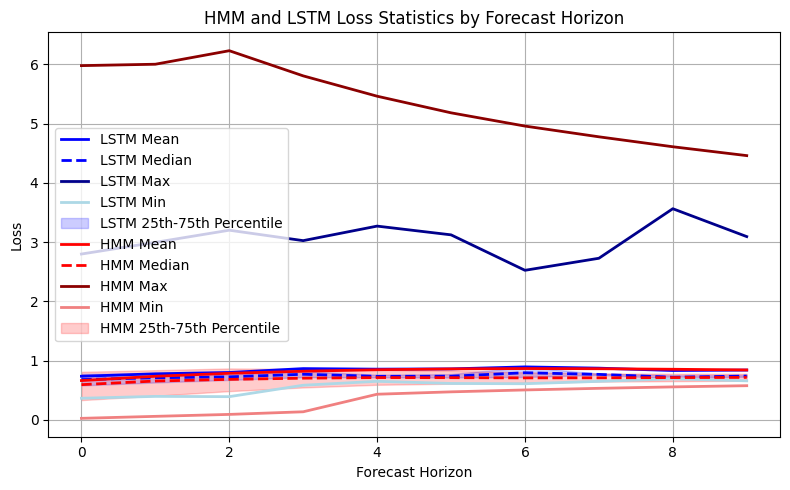

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))

horizons = lstm_stats_df.index

# Plot LSTM stats
ax.plot(horizons, lstm_stats_df['mean'], label='LSTM Mean', color='blue', linewidth=2)
ax.plot(horizons, lstm_stats_df['median'], label='LSTM Median', color='blue', linestyle='--', linewidth=2)
ax.plot(horizons, lstm_stats_df['max'], label='LSTM Max', color='darkblue', linewidth=2)
ax.plot(horizons, lstm_stats_df['min'], label='LSTM Min', color='lightblue', linewidth=2)
ax.fill_between(horizons, lstm_stats_df['P25'], lstm_stats_df['P75'], color='blue', alpha=0.2, label='LSTM 25th-75th Percentile')

# plot HMM stats
ax.plot(horizons, hmm_stats_df['mean'], label='HMM Mean', color='red', linewidth=2)
ax.plot(horizons, hmm_stats_df['median'], label='HMM Median', color='red', linestyle='--', linewidth=2)
ax.plot(horizons, hmm_stats_df['max'], label='HMM Max', color='darkred', linewidth=2)
ax.plot(horizons, hmm_stats_df['min'], label='HMM Min', color='lightcoral', linewidth=2)
ax.fill_between(horizons, hmm_stats_df['P25'], hmm_stats_df['P75'], color='red', alpha=0.2, label='HMM 25th-75th Percentile')

ax.set_xlabel('Forecast Horizon')
ax.set_ylabel('Loss')
ax.set_title('HMM and LSTM Loss Statistics by Forecast Horizon')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

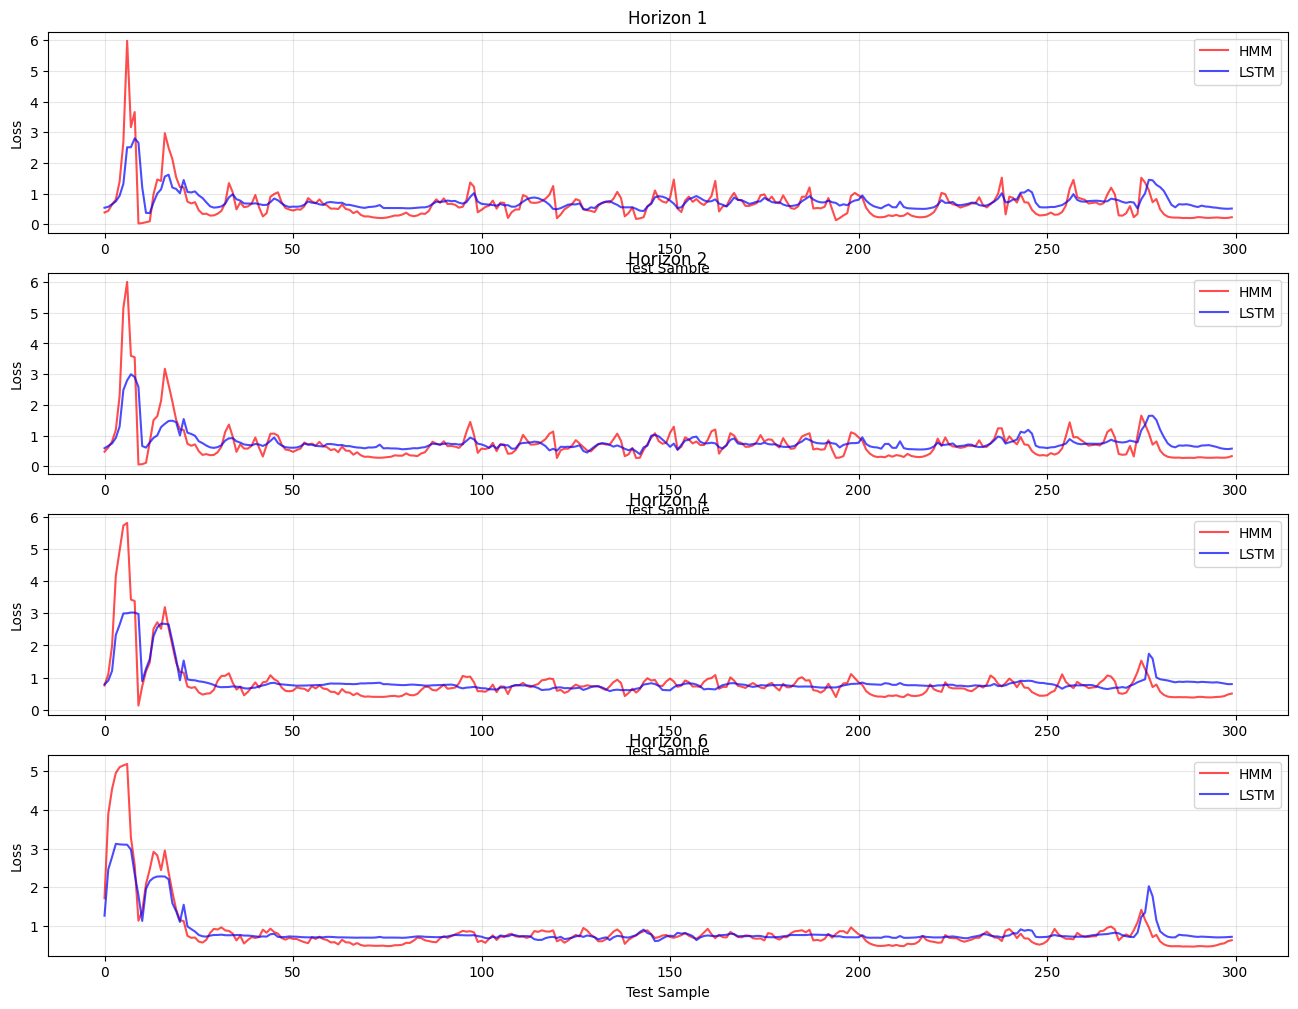

In [21]:
plt.figure(figsize=(16, 12))

# Horizon indices (0-based): 0, 1, 3
horizons = [0, 1, 3, 5]
titles = ['Horizon 1', 'Horizon 2', 'Horizon 4', 'Horizon 6']

for i, horizon in enumerate(horizons):
    ax = plt.subplot(4, 1, i + 1)
    ax.plot(hmm_state_losses[:, horizon], label='HMM', color='red', alpha=0.7)
    ax.plot(lstm_state_losses[:, horizon], label='LSTM', color='blue', alpha=0.7)
    ax.set_title(titles[i])
    ax.set_xlabel('Test Sample')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

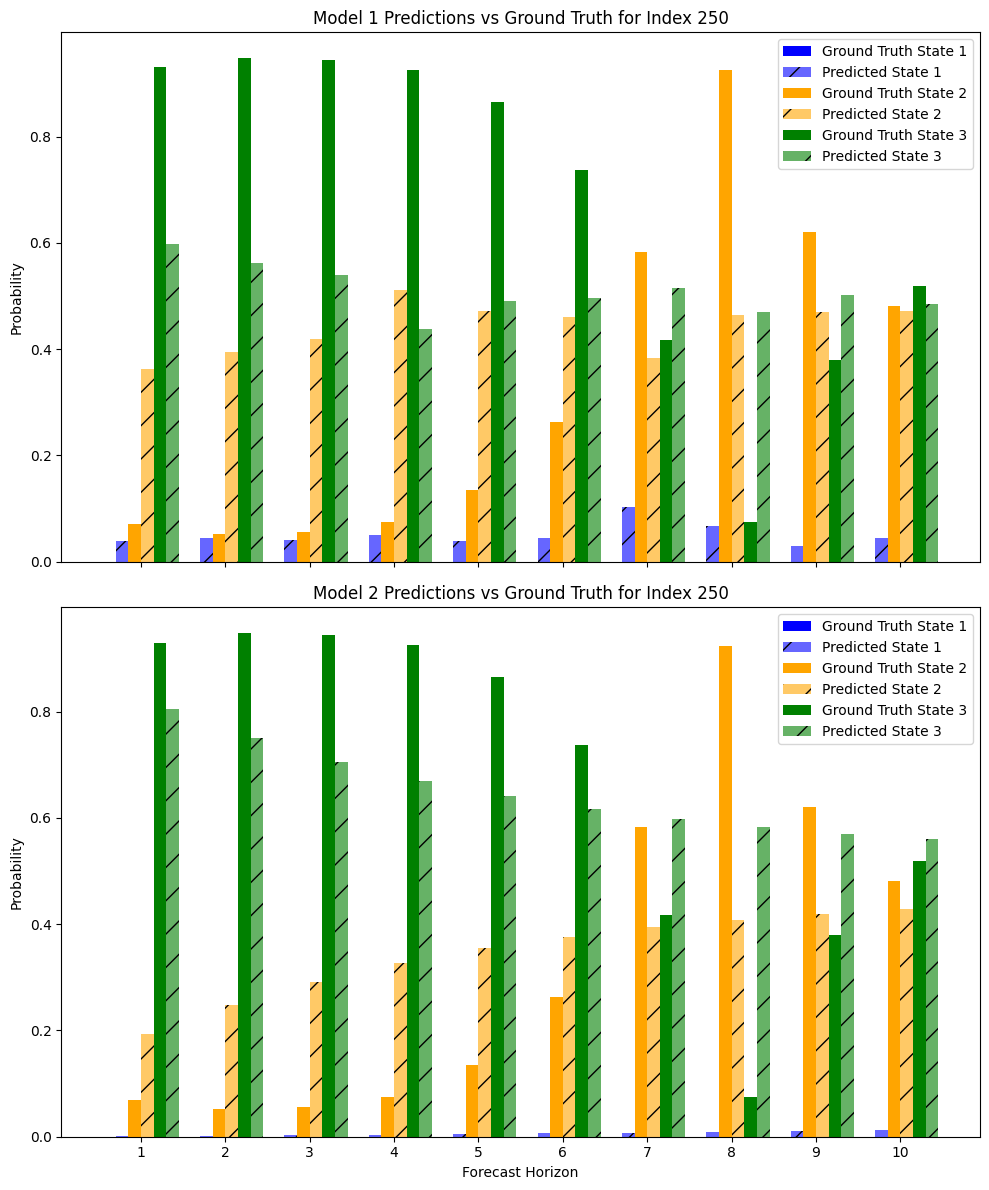

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison_bars(model_1_predictions, model_2_predictions, ground_truth, index):
    # Assuming lstm_predictions, lstm_ground_truth, hmm_predictions, and hmm_ground_truth are defined as 3D arrays (e.g., shape: samples, horizons, states)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
    forecast_range = np.arange(model_1_predictions.shape[1])
    bar_width = 0.15
    # Plot for Model 1 on ax1
    for state, color in zip(range(n_states), ['blue', 'orange', 'green']):
        offset = state * (bar_width * 2)
        # Plot ground truth (solid, opaque)
        ax1.bar(
            forecast_range + offset,
            ground_truth[index, :, state],
            width=bar_width,
            label=f'Ground Truth State {state+1}',
            color=color,
            alpha=1
        )
        # Plot predictions (with striped pattern for distinction)
        ax1.bar(
            forecast_range + offset + bar_width,
            model_1_predictions[index, :, state],
            width=bar_width,
            label=f'Predicted State {state+1}',
            color=color,
            alpha=0.6,
            hatch='/'
        )

    # Avoid duplicate labels in legend for ax1
    handles1, labels1 = ax1.get_legend_handles_labels()
    unique1 = dict(zip(labels1, handles1))
    ax1.legend(unique1.values(), unique1.keys())
    ax1.set_ylabel('Probability')
    ax1.set_title(f'Model 1 Predictions vs Ground Truth for Index {index}')

    # Plot for Model 2 on ax2
    for state, color in zip(range(n_states), ['blue', 'orange', 'green']):
        offset = state * (bar_width * 2)
        # Plot ground truth (solid, opaque)
        ax2.bar(
            forecast_range + offset,
            ground_truth[index, :, state],
            width=bar_width,
            label=f'Ground Truth State {state+1}',
            color=color,
            alpha=1
        )
        # Plot predictions (with striped pattern for distinction)
        ax2.bar(
            forecast_range + offset + bar_width,
            model_2_predictions[index, :, state],
            width=bar_width,
            label=f'Predicted State {state+1}',
            color=color,
            alpha=0.6,
            hatch='/'
        )

    # Avoid duplicate labels in legend for ax2
    handles2, labels2 = ax2.get_legend_handles_labels()
    unique2 = dict(zip(labels2, handles2))
    ax2.legend(unique2.values(), unique2.keys())
    ax2.set_xlabel('Forecast Horizon')
    ax2.set_ylabel('Probability')
    ax2.set_title(f'Model 2 Predictions vs Ground Truth for Index {index}')

    # Set x-ticks centered for each group
    xtick_positions = forecast_range + bar_width * 2.5
    ax2.set_xticks(xtick_positions)
    ax2.set_xticklabels([str(i+1) for i in forecast_range])

    plt.tight_layout()
    plt.show()

plot_comparison_bars(lstm_predictions, hmm_predictions, lstm_ground_truth, index=250)

### Get uncertainty metrics

In [48]:
# Define the mc_dropout_predictions function
def mc_dropout_predictions(model, X, Y_true=None, num_samples=1000):
    
    predictions = np.stack([model(X, training=True) for _ in range(num_samples)], axis=0)
    probs, alpha, S = dirichlet_layer(predictions)
    num_examples, num_classes = probs.shape[1], probs.shape[2]
    mean_probs = np.mean(probs, axis=0)
    mean_S = np.mean(S, axis=0)
    std_S = np.std(S, axis=0)
    epsilon = 1e-10
    entropy = -np.sum(mean_probs * np.log(mean_probs + epsilon), axis=1, keepdims=True)
    std_dev = np.std(probs, axis=0)
    mean_std_dev = np.mean(std_dev, axis=1, keepdims=True)
    max_std_dev = np.max(std_dev, axis=1, keepdims=True)
    per_sample_loss = np.zeros((num_examples, 1))
    if Y_true is not None:
        Y_true = np.asarray(Y_true)
        cross_entropy = -np.sum(Y_true * np.log(mean_probs + epsilon), axis=1, keepdims=True)
        per_sample_loss = cross_entropy
    df = pd.DataFrame()

    df[[f'Class_{i}_True' for i in range(num_classes)]] = Y_true
    df[[f'Class_{i}_Prob' for i in range(num_classes)]] = mean_probs
    df['Predictive_Entropy'] = entropy
    for i in range(num_classes):
        df[f'Class_{i}_StdDev'] = std_dev[:, i]
    df['Mean_StdDev'] = mean_std_dev
    df['Max_StdDev'] = max_std_dev
    df['Per_Sample_Loss'] = per_sample_loss
    df['Per_sample_uncertainty_mean'] = mean_S
    df['Per_sample_uncertainty_std'] = std_S
    if len(X) == hmm_state_losses.shape[0]:
        df['hmm_loss'] = hmm_state_losses[:, forecast_horizon]
    elif len(X) == hmm_valid_loss.shape[0]:
        df['hmm_loss'] = hmm_valid_loss[:, forecast_horizon]
    else:
        df['hmm_loss'] = np.zeros((len(X),))
    df['loss_difference'] = df['Per_Sample_Loss'] - df['hmm_loss']

    return df

In [49]:
uncertainty_dfs = []
for i, model in enumerate(model_list):
    uncertainty_df = mc_dropout_predictions(model, X_valid, Y_valid[:, i, :], num_samples=100)
    uncertainty_dfs.append(uncertainty_df)

In [51]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Loop over all dfs and construct results dataframe
results = []
reg_models = []
for i, df in enumerate(uncertainty_dfs):
    corr = df[['loss_difference', 'Predictive_Entropy', 'Mean_StdDev', 'Max_StdDev', 'Per_sample_uncertainty_mean']].corr()[['loss_difference']]
    X = df[['Predictive_Entropy', 'Mean_StdDev', 'Per_sample_uncertainty_mean', 'Per_sample_uncertainty_std']].values
    y = df['loss_difference'].values
    
    reg = LinearRegression().fit(X, y)
    r_sq = reg.score(X, y)
    mult_corr = np.sqrt(r_sq)

    reg_models.append(reg)
    
    results.append({
        'horizon': i,
        'Predictive_Entropy': corr.loc['Predictive_Entropy', 'loss_difference'],
        'Mean_StdDev': corr.loc['Mean_StdDev', 'loss_difference'],
        'Max_StdDev': corr.loc['Max_StdDev', 'loss_difference'],
        'Per_sample_uncertainty_mean': corr.loc['Per_sample_uncertainty_mean', 'loss_difference'],
        'multiple_correlation': mult_corr
    })

correlation = pd.DataFrame(results)
correlation

,horizon,Predictive_Entropy,Mean_StdDev,Max_StdDev,Per_sample_uncertainty_mean,multiple_correlation
0,0,0.308719,0.245929,0.178506,-0.316634,0.361772
1,1,0.565453,0.521448,0.486322,-0.436099,0.571513
2,2,0.312874,0.275273,0.235609,-0.288257,0.330188
3,3,0.331765,0.310774,0.286043,0.149165,0.400518
4,4,0.207711,0.217203,0.216289,-0.078694,0.225272
5,5,0.326172,0.304733,0.299327,-0.227808,0.336963
6,6,0.292058,0.267504,0.255633,-0.270242,0.297038
7,7,0.209776,0.096642,0.100321,-0.176285,0.227583
8,8,-0.030721,-0.089762,-0.102987,-0.100119,0.178797
9,9,0.140810,0.086901,0.092605,-0.183736,0.189842


In [56]:
test_uncertainty_dfs = []
for i, model in enumerate(model_list):
    test_uncertainty_df = mc_dropout_predictions(model, X_test, Y_test[:, i, :], num_samples=100)
    test_uncertainty_dfs.append(test_uncertainty_df)

certainty_scores = []
for i, df in enumerate(test_uncertainty_dfs):
    reg = reg_models[i]
    X = df[['Predictive_Entropy', 'Mean_StdDev', 'Per_sample_uncertainty_mean', 'Per_sample_uncertainty_std']].values
    score = reg.predict(X)
    certainty_scores.append(score)  # Negate to get certainty score


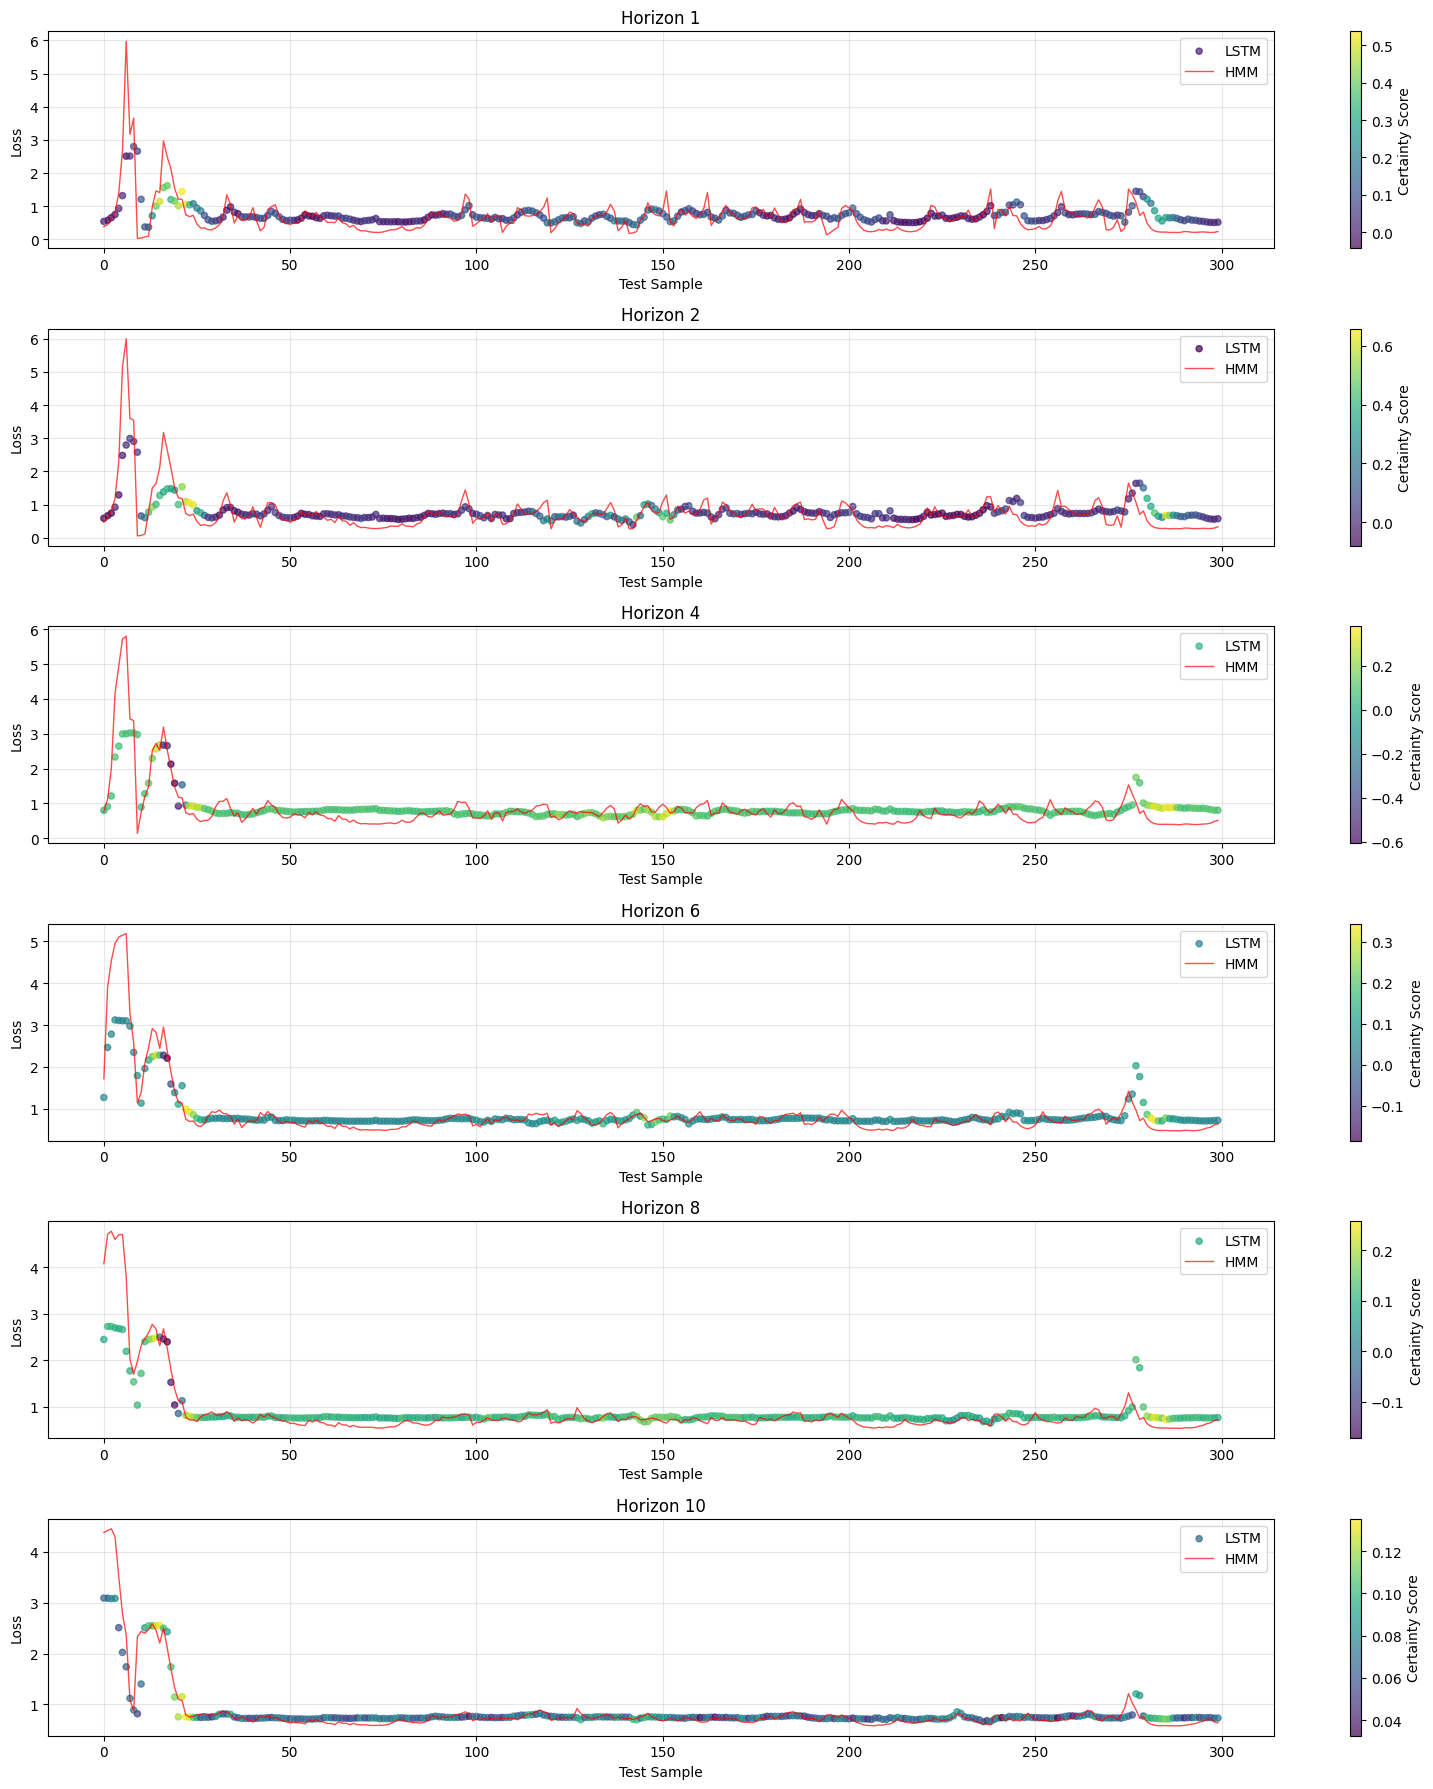

In [57]:
# Horizon indices (0-based): 0, 1, 3
horizons = [0, 1, 3, 5, 7, 9]
titles = ['Horizon 1', 'Horizon 2', 'Horizon 4', 'Horizon 6', 'Horizon 8', 'Horizon 10']

plt.figure(figsize=(16, 18))

for i, horizon in enumerate(horizons):
    ax = plt.subplot(6, 1, i + 1)
    
    # Create scatter plot for LSTM colored by certainty scores
    scatter = ax.scatter(range(len(lstm_state_losses[:, horizon])), 
                        lstm_state_losses[:, horizon], 
                        c=certainty_scores[horizon], 
                        cmap='viridis', 
                        label='LSTM', 
                        alpha=0.7, 
                        s=20)
    
    # Plot HMM losses
    ax.plot(hmm_state_losses[:, horizon], 
           label='HMM', 
           color='red', 
           alpha=0.7, 
           linewidth=1)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Certainty Score')
    
    ax.set_title(titles[i])
    ax.set_xlabel('Test Sample')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()